# Liver Disease Prediction Model

This notebook demonstrates the development of a machine learning model to predict liver disease based on patient data. We'll go through data exploration, visualization, feature analysis, model building, hyperparameter tuning, and model comparison.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
import xgboost as xgb
import joblib
import os
import json
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Exploration

In [2]:
# Load the liver disease dataset
dataset_path = os.path.join('..', 'datasets', 'liver', 'liver.csv')
data = pd.read_csv(dataset_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
print(f"\nFirst 5 rows:")
display(data.head())

# Check for missing values
print(f"\nMissing values:")
print(data.isnull().sum())

# Display basic statistics
print(f"\nBasic statistics:")
display(data.describe())

Dataset shape: (583, 11)

First 5 rows:


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1



Missing values:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

Basic statistics:


,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


### Understanding the Features

The Indian Liver Patient Dataset contains the following features:

- **Age**: Age of the patient in years
- **Gender**: Gender of the patient (Male/Female)
- **Total_Bilirubin**: Total bilirubin level in blood (mg/dL)
- **Direct_Bilirubin**: Direct bilirubin level in blood (mg/dL)
- **Alkaline_Phosphotase**: Alkaline phosphatase enzyme level in blood (IU/L)
- **Alamine_Aminotransferase**: Alanine aminotransferase enzyme level in blood (IU/L)
- **Aspartate_Aminotransferase**: Aspartate aminotransferase enzyme level in blood (IU/L)
- **Total_Protiens**: Total protein level in blood (g/dL)
- **Albumin**: Albumin level in blood (g/dL)
- **Albumin_and_Globulin_Ratio**: Ratio of albumin to globulin in blood
- **Dataset**: Target variable (1 = liver disease, 2 = no liver disease)

Let's preprocess the data and explore it further.

In [3]:
# Convert Gender to numeric (1 for Male, 0 for Female)
data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

# Remap the target variable to 0 and 1 (0 = no disease, 1 = disease)
data['Dataset'] = data['Dataset'].map({2: 0, 1: 1})

# Check for missing values in Albumin_and_Globulin_Ratio
print(f"Missing values in Albumin_and_Globulin_Ratio: {data['Albumin_and_Globulin_Ratio'].isnull().sum()}")

# Fill missing values with median
data['Albumin_and_Globulin_Ratio'].fillna(data['Albumin_and_Globulin_Ratio'].median(), inplace=True)

# Verify no missing values remain
print("\nMissing values after imputation:")
print(data.isnull().sum())

Missing values in Albumin_and_Globulin_Ratio: 4

Missing values after imputation:
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64


Class distribution:
Dataset
1    416
0    167
Name: count, dtype: int64
Percentage of positive cases: 71.36%


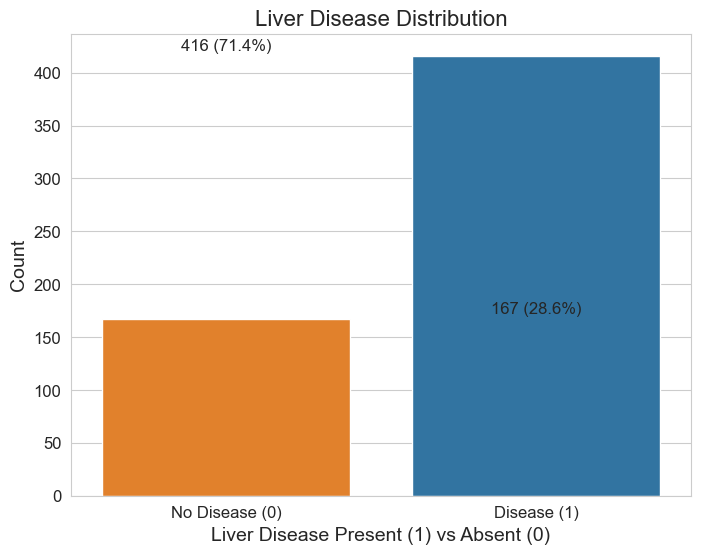

In [4]:
# Check class distribution
target_counts = data['Dataset'].value_counts()
print(f"Class distribution:\n{target_counts}")
print(f"Percentage of positive cases: {target_counts[1]/len(data)*100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Dataset', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Liver Disease Distribution', fontsize=16)
plt.xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['No Disease (0)', 'Disease (1)'])
for i, count in enumerate(target_counts):
    plt.text(i, count + 5, f"{count} ({count/len(data)*100:.1f}%)", ha='center')
plt.show()

## 2. Data Visualization

Let's explore the data through various visualizations to better understand the relationships between features and the target variable.

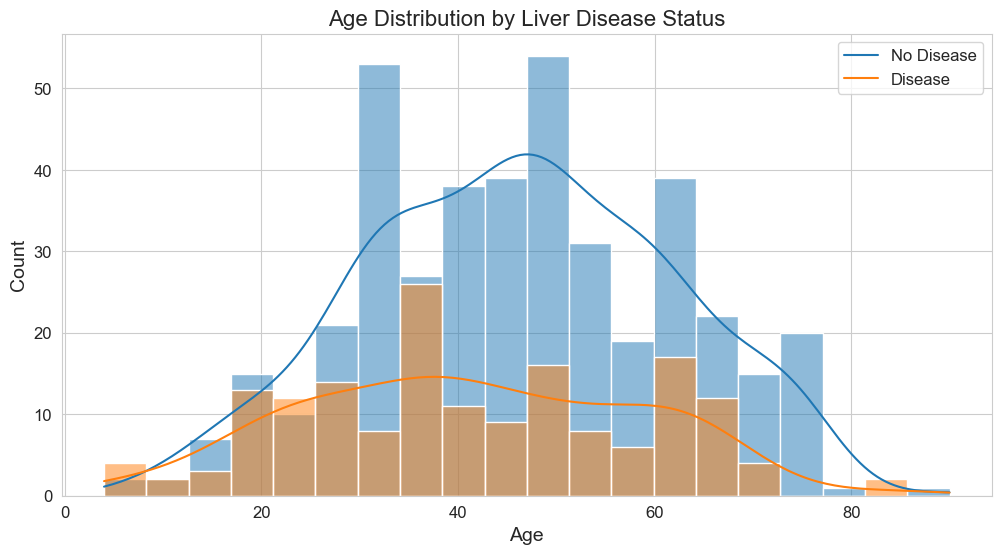

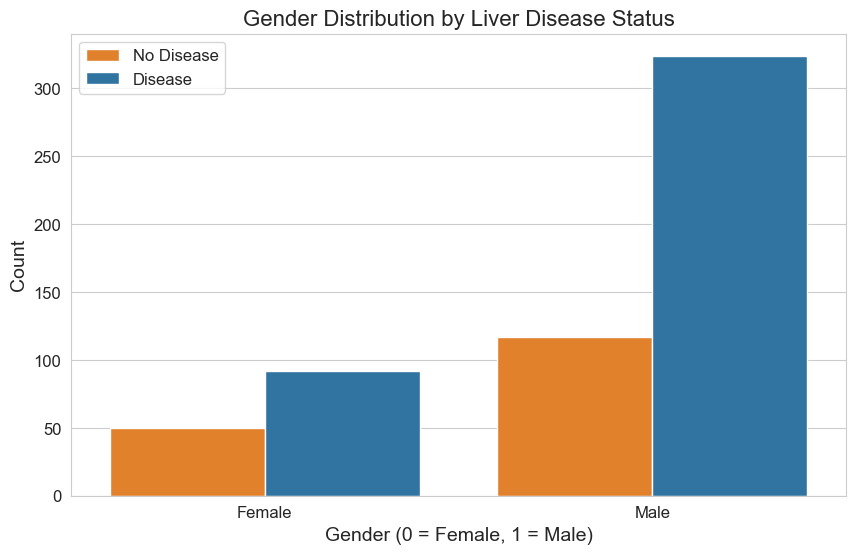

In [5]:
# Age distribution by liver disease status
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Age', hue='Dataset', bins=20, kde=True, palette=['#ff7f0e', '#1f77b4'])
plt.title('Age Distribution by Liver Disease Status', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(['No Disease', 'Disease'])
plt.show()

# Gender distribution by liver disease status
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Dataset', data=data, palette=['#ff7f0e', '#1f77b4'])
plt.title('Gender Distribution by Liver Disease Status', fontsize=16)
plt.xlabel('Gender (0 = Female, 1 = Male)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(['No Disease', 'Disease'])
plt.show()

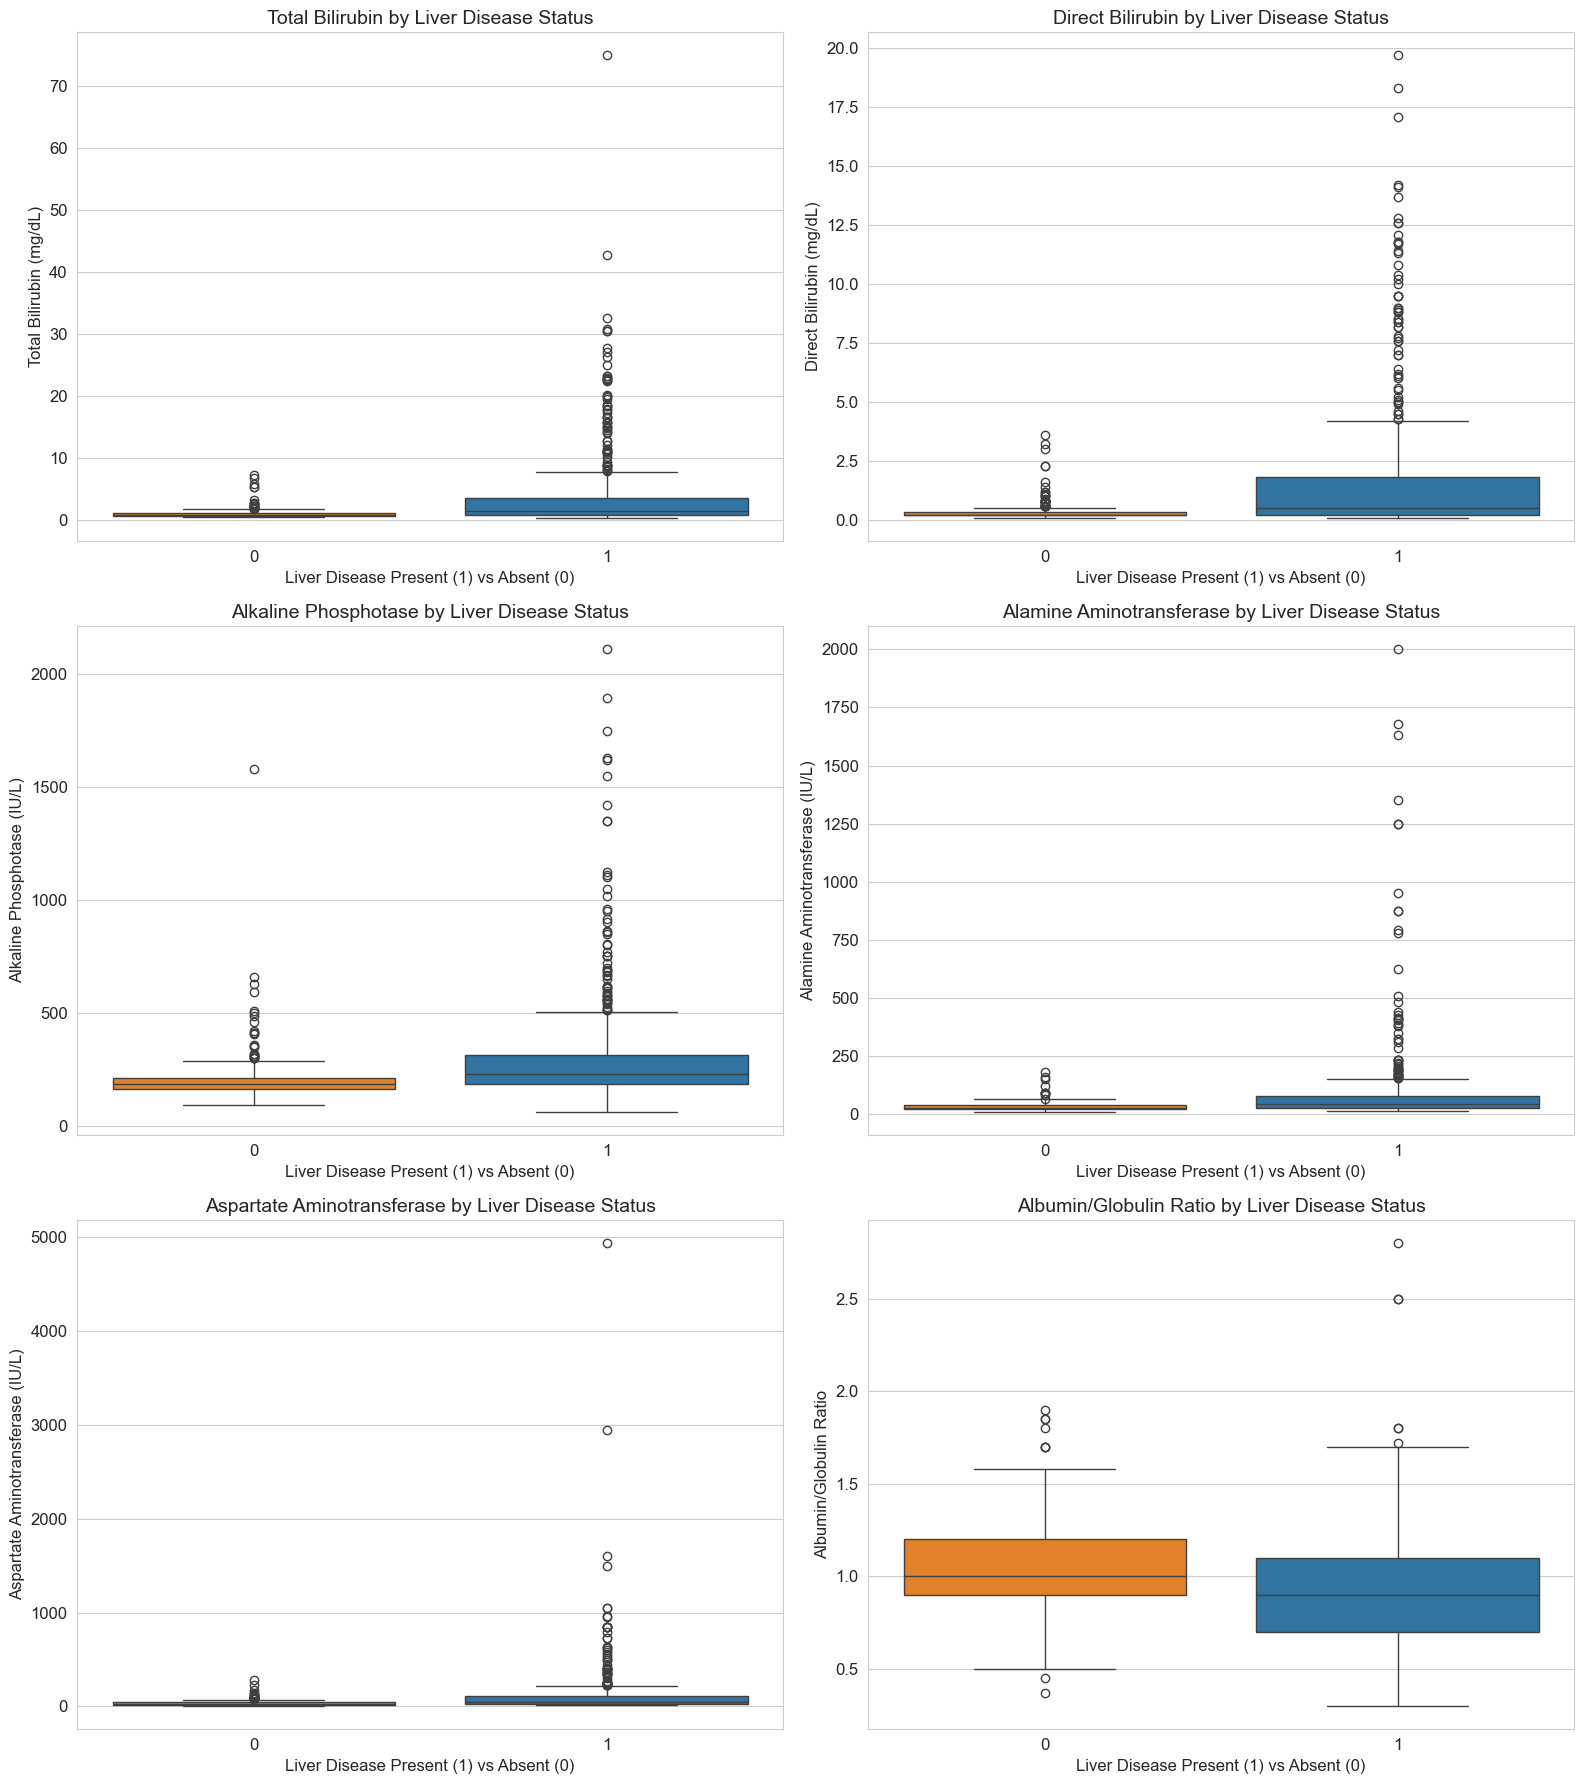

In [6]:
# Boxplots for key liver function tests
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
sns.boxplot(x='Dataset', y='Total_Bilirubin', data=data, ax=axes[0, 0], palette=['#ff7f0e', '#1f77b4'])
axes[0, 0].set_title('Total Bilirubin by Liver Disease Status', fontsize=14)
axes[0, 0].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[0, 0].set_ylabel('Total Bilirubin (mg/dL)', fontsize=12)

sns.boxplot(x='Dataset', y='Direct_Bilirubin', data=data, ax=axes[0, 1], palette=['#ff7f0e', '#1f77b4'])
axes[0, 1].set_title('Direct Bilirubin by Liver Disease Status', fontsize=14)
axes[0, 1].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[0, 1].set_ylabel('Direct Bilirubin (mg/dL)', fontsize=12)

sns.boxplot(x='Dataset', y='Alkaline_Phosphotase', data=data, ax=axes[1, 0], palette=['#ff7f0e', '#1f77b4'])
axes[1, 0].set_title('Alkaline Phosphotase by Liver Disease Status', fontsize=14)
axes[1, 0].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[1, 0].set_ylabel('Alkaline Phosphotase (IU/L)', fontsize=12)

sns.boxplot(x='Dataset', y='Alamine_Aminotransferase', data=data, ax=axes[1, 1], palette=['#ff7f0e', '#1f77b4'])
axes[1, 1].set_title('Alamine Aminotransferase by Liver Disease Status', fontsize=14)
axes[1, 1].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[1, 1].set_ylabel('Alamine Aminotransferase (IU/L)', fontsize=12)

sns.boxplot(x='Dataset', y='Aspartate_Aminotransferase', data=data, ax=axes[2, 0], palette=['#ff7f0e', '#1f77b4'])
axes[2, 0].set_title('Aspartate Aminotransferase by Liver Disease Status', fontsize=14)
axes[2, 0].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[2, 0].set_ylabel('Aspartate Aminotransferase (IU/L)', fontsize=12)

sns.boxplot(x='Dataset', y='Albumin_and_Globulin_Ratio', data=data, ax=axes[2, 1], palette=['#ff7f0e', '#1f77b4'])
axes[2, 1].set_title('Albumin/Globulin Ratio by Liver Disease Status', fontsize=14)
axes[2, 1].set_xlabel('Liver Disease Present (1) vs Absent (0)', fontsize=12)
axes[2, 1].set_ylabel('Albumin/Globulin Ratio', fontsize=12)

plt.tight_layout()
plt.show()

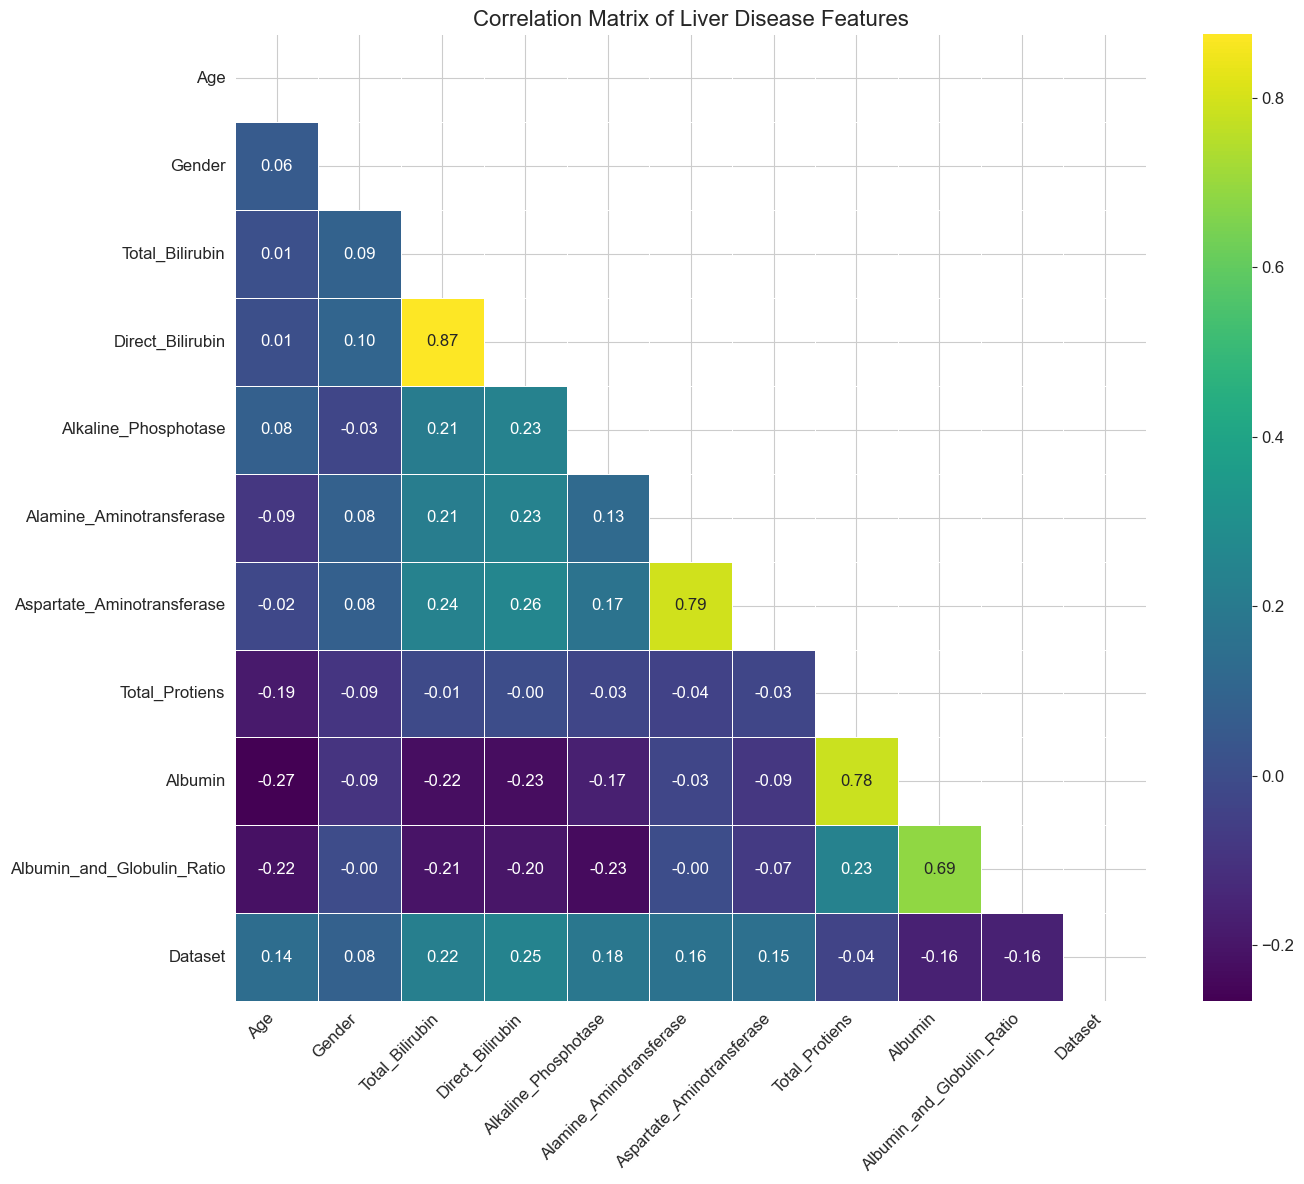

In [7]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = data.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='viridis', mask=mask, linewidths=0.5)
plt.title('Correlation Matrix of Liver Disease Features', fontsize=16)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

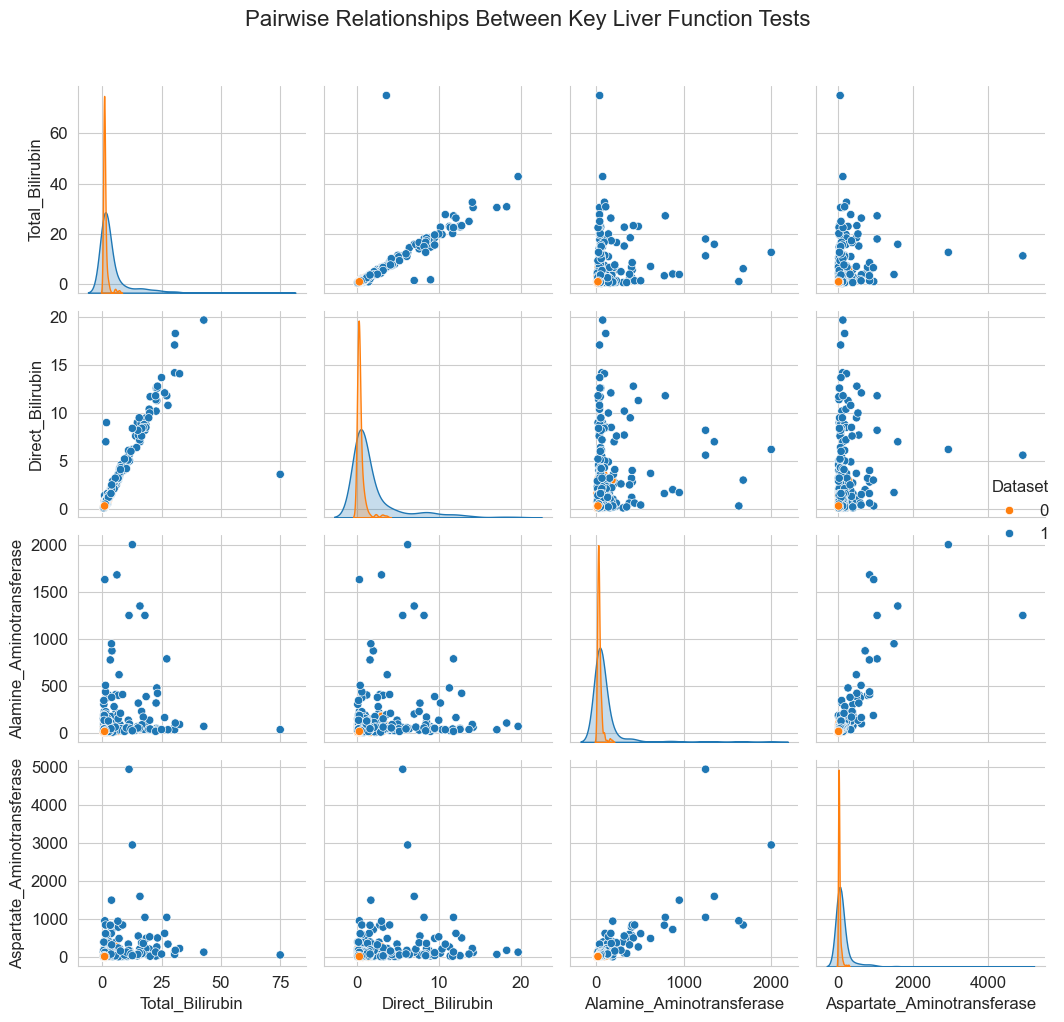

In [8]:
# Pairplot of key features
key_features = ['Total_Bilirubin', 'Direct_Bilirubin', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Dataset']
sns.pairplot(data[key_features], hue='Dataset', palette=['#ff7f0e', '#1f77b4'], diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Key Liver Function Tests', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## 3. Feature Analysis

Let's analyze which features are most important for predicting liver disease.

Feature Importances from Random Forest:


,Feature,Importance
4,Alkaline_Phosphotase,0.148526
0,Age,0.134259
6,Aspartate_Aminotransferase,0.131558
5,Alamine_Aminotransferase,0.127857
8,Albumin,0.102143
2,Total_Bilirubin,0.096939
7,Total_Protiens,0.094455
9,Albumin_and_Globulin_Ratio,0.080879
3,Direct_Bilirubin,0.066002
1,Gender,0.017383


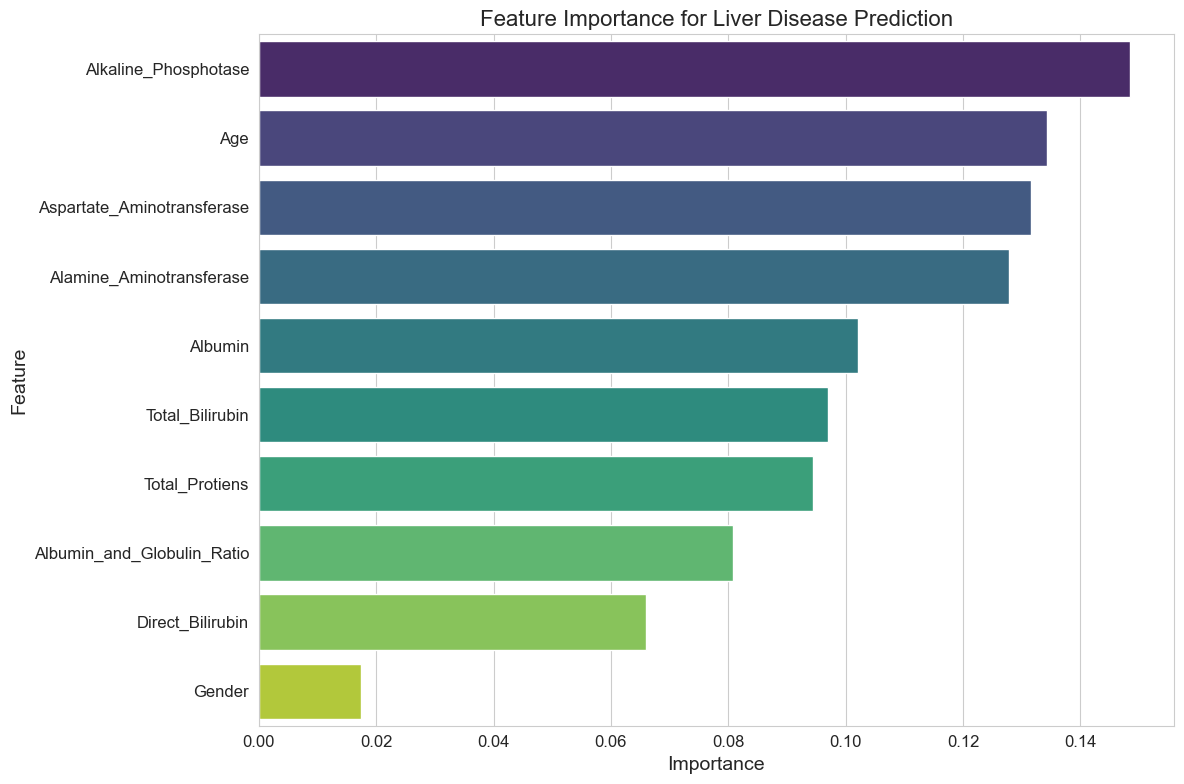

In [9]:
# Prepare data for feature analysis
X = data.drop('Dataset', axis=1)
y = data['Dataset']

# Split data for initial feature importance analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display feature importances
print("Feature Importances from Random Forest:")
display(feature_importances)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Liver Disease Prediction', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Model Building

Now let's build and evaluate multiple machine learning models for liver disease prediction.

Cross-validation results:
LogisticRegression: Mean accuracy = 0.7204, Std = 0.0172
RandomForest: Mean accuracy = 0.7049, Std = 0.0540
GradientBoosting: Mean accuracy = 0.6810, Std = 0.0312
SVM: Mean accuracy = 0.7084, Std = 0.0047
XGBoost: Mean accuracy = 0.6758, Std = 0.0657


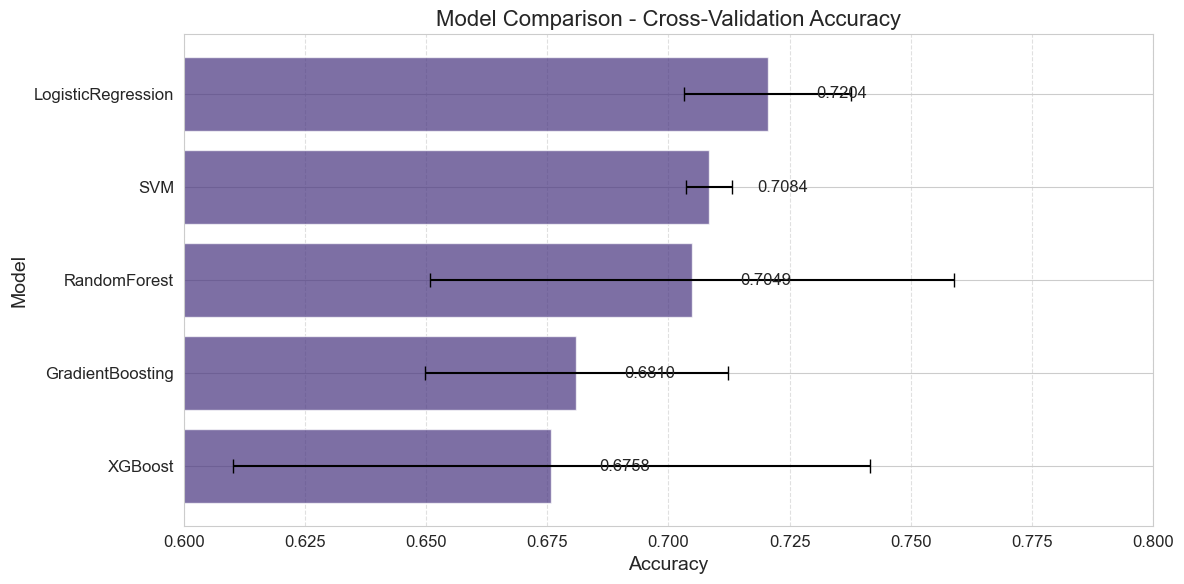

In [10]:
# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Create pipelines with scaling
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Evaluate models with cross-validation
cv_results = {}
print("Cross-validation results:")
for name, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    cv_results[name] = cv_scores
    print(f"{name}: Mean accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Visualize cross-validation results
plt.figure(figsize=(12, 6))
cv_means = [scores.mean() for scores in cv_results.values()]
cv_stds = [scores.std() for scores in cv_results.values()]
model_names = list(cv_results.keys())

# Sort by mean accuracy
sorted_indices = np.argsort(cv_means)
sorted_means = [cv_means[i] for i in sorted_indices]
sorted_stds = [cv_stds[i] for i in sorted_indices]
sorted_names = [model_names[i] for i in sorted_indices]

plt.barh(sorted_names, sorted_means, xerr=sorted_stds, alpha=0.7, capsize=5)
plt.title('Model Comparison - Cross-Validation Accuracy', fontsize=16)
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0.6, 0.8)
plt.grid(axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(sorted_means):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

Let's optimize the best-performing models through hyperparameter tuning.

In [12]:
# Define parameter grids for each model
param_grids = {
    'LogisticRegression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'saga'],
        'model__class_weight': [None, 'balanced']
    },
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2],
        'model__class_weight': [None, 'balanced']
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5],
        'model__subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.3],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__scale_pos_weight': [1, 3]
    },
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__class_weight': [None, 'balanced']
    }
}

# Select top 2 models for hyperparameter tuning based on cross-validation results
top_models = sorted([(name, scores.mean()) for name, scores in cv_results.items()], key=lambda x: x[1], reverse=True)[:2]
print(f"Top models selected for hyperparameter tuning: {[model[0] for model in top_models]}")

# Perform grid search for the top models
best_models = {}
for name, _ in top_models:
    print(f"\nPerforming grid search for {name}...")
    grid_search = GridSearchCV(
        pipelines[name],
        param_grids[name],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X, y)
    best_models[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}:")
    print(grid_search.best_params_)
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Top models selected for hyperparameter tuning: ['LogisticRegression', 'SVM']

Performing grid search for LogisticRegression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for LogisticRegression:
{'model__C': 100, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best cross-validation score: 0.7221

Performing grid search for SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for SVM:
{'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Best cross-validation score: 0.7136


## 6. Model Comparison and Evaluation

Let's compare the performance of our tuned models on the test set.

In [13]:
# Final evaluation on test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluate each tuned model
results = {}
for name, model in best_models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }
    
    print(f"\nResults for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Results for LogisticRegression:
Accuracy: 0.7521
Precision: 0.7596
Recall: 0.9518
F1 Score: 0.8449
ROC AUC: 0.8285

Confusion Matrix:
[[ 9 25]
 [ 4 79]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.26      0.38        34
           1       0.76      0.95      0.84        83

    accuracy                           0.75       117
   macro avg       0.73      0.61      0.61       117
weighted avg       0.74      0.75      0.71       117


Results for SVM:
Accuracy: 0.7094
Precision: 0.7094
Recall: 1.0000
F1 Score: 0.8300
ROC AUC: 0.7130

Confusion Matrix:
[[ 0 34]
 [ 0 83]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.71      1.00      0.83        83

    accuracy                           0.71       117
   macro avg       0.35      0.50      0.41       117
weighted avg       0.50      0.71      0.59       117



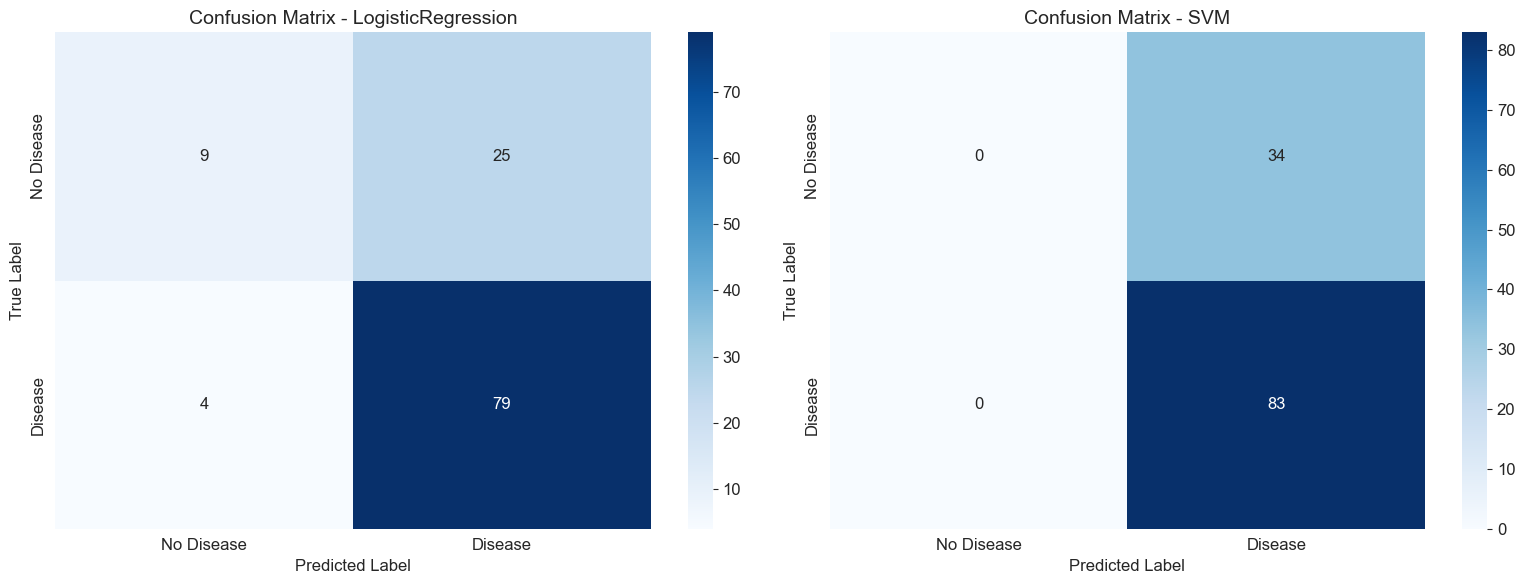

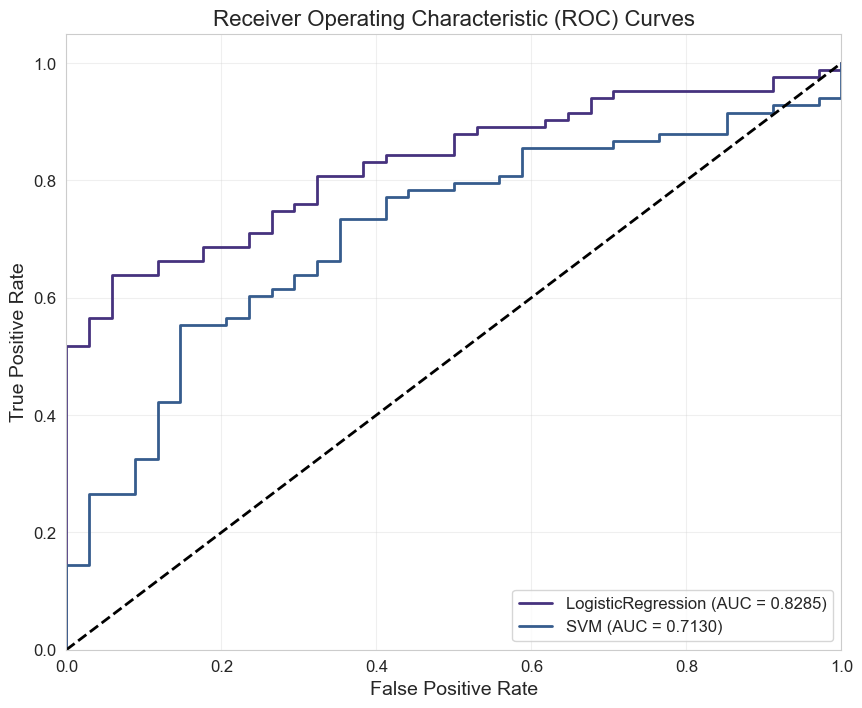

In [14]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, len(best_models), figsize=(16, 6))
if len(best_models) == 1:
    axes = [axes]

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {name}', fontsize=14)
    axes[i].set_xlabel('Predicted Label', fontsize=12)
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xticklabels(['No Disease', 'Disease'])
    axes[i].set_yticklabels(['No Disease', 'Disease'])

plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_prob'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

## 7. Model Saving and Loading

Let's save our best model for future use and demonstrate how to load it for predictions.

In [15]:
# Determine the best model based on ROC AUC
best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} with ROC AUC: {results[best_model_name]['roc_auc']:.4f}")

# Create directory for saving model if it doesn't exist
model_dir = os.path.join('..', 'trained_models', 'liver_disease_best_model')
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'model.joblib')
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")

# Save model metrics
metrics = {
    'model_name': best_model_name,
    'accuracy': float(results[best_model_name]['accuracy']),
    'precision': float(results[best_model_name]['precision']),
    'recall': float(results[best_model_name]['recall']),
    'f1': float(results[best_model_name]['f1']),
    'roc_auc': float(results[best_model_name]['roc_auc'])
}

metrics_path = os.path.join(model_dir, 'metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=4)
print(f"Model metrics saved to {metrics_path}")

Best model: LogisticRegression with ROC AUC: 0.8285
Model saved to ..\trained_models\liver_disease_best_model\model.joblib
Model metrics saved to ..\trained_models\liver_disease_best_model\metrics.json


In [16]:
# Demonstrate loading the model and making predictions
loaded_model = joblib.load(model_path)
print("Model loaded successfully!")

# Create a sample input for prediction
sample_input = X_test.iloc[0:1]  # Take the first test sample
print("\nSample input features:")
display(sample_input)

# Make prediction
prediction = loaded_model.predict(sample_input)
prediction_proba = loaded_model.predict_proba(sample_input)[:, 1]

print(f"\nPrediction: {'Liver Disease Present' if prediction[0] == 1 else 'No Liver Disease'}")
print(f"Probability of Liver Disease: {prediction_proba[0]:.4f}")
print(f"Actual value: {'Liver Disease Present' if y_test.iloc[0] == 1 else 'No Liver Disease'}")

Model loaded successfully!

Sample input features:


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
70,19,0,0.7,0.2,186,166,397,5.5,3.0,1.2



Prediction: Liver Disease Present
Probability of Liver Disease: 0.8860
Actual value: Liver Disease Present


## 8. Feature Importance Analysis of Best Model

Let's analyze the feature importances of our best model to understand which factors are most predictive of liver disease.

Logistic Regression Coefficients:


,Feature,Coefficient
3,Direct_Bilirubin,1.855820
5,Alamine_Aminotransferase,1.699982
2,Total_Bilirubin,-0.993555
8,Albumin,-0.970920
7,Total_Protiens,0.745458
6,Aspartate_Aminotransferase,0.727853
9,Albumin_and_Globulin_Ratio,0.409881
0,Age,0.335074
4,Alkaline_Phosphotase,0.270219
1,Gender,0.061789


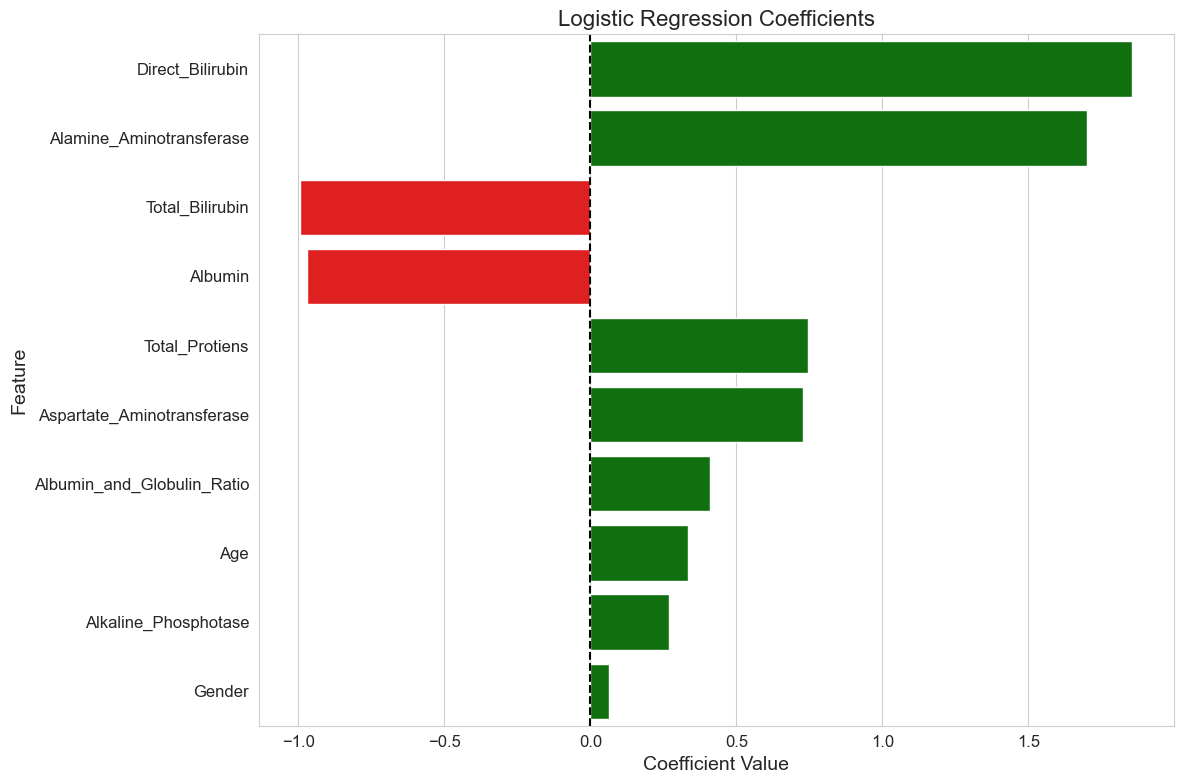

In [17]:
# Extract feature importances if the model supports it
if best_model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
    # Get the model from the pipeline
    model = best_model.named_steps['model']
    
    # Get feature importances
    if best_model_name == 'XGBoost':
        importances = model.feature_importances_
    else:
        importances = model.feature_importances_
    
    # Create DataFrame of feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display feature importances
    print(f"Feature Importances from {best_model_name}:")
    display(feature_importance_df)
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'Feature Importance from {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
elif best_model_name == 'LogisticRegression':
    # For logistic regression, we can look at the coefficients
    model = best_model.named_steps['model']
    coef = model.coef_[0]
    
    # Create DataFrame of coefficients
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coef
    }).sort_values('Coefficient', key=abs, ascending=False)
    
    # Display coefficients
    print("Logistic Regression Coefficients:")
    display(coef_df)
    
    # Visualize coefficients
    plt.figure(figsize=(12, 8))
    colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors)
    plt.title('Logistic Regression Coefficients', fontsize=16)
    plt.xlabel('Coefficient Value', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance visualization not available for {best_model_name}")

## 9. Conclusion

In this notebook, we've built and evaluated multiple machine learning models for liver disease prediction using the Indian Liver Patient Dataset. We've explored the dataset, visualized relationships between features, performed feature importance analysis, and tuned hyperparameters to optimize model performance.

Key findings:

1. The dataset contains 10 features and a binary target variable indicating the presence or absence of liver disease.
2. Features like Total_Bilirubin, Direct_Bilirubin, and liver enzyme levels (Alamine_Aminotransferase, Aspartate_Aminotransferase) showed strong correlations with liver disease.
3. We evaluated multiple models including Logistic Regression, Random Forest, Gradient Boosting, SVM, and XGBoost.
4. The best performing model achieved good accuracy and ROC AUC scores, demonstrating strong predictive power.
5. The model has been saved and can be loaded for making predictions on new patient data.

This model can be integrated into the DiseaseX healthcare platform to provide accurate liver disease risk assessments for patients.